# In-class assignment: Convolution and filtering
## 02.01.2019

In project 1, we discussed the geometry of image formation, and how to map from coordinates in the real world to coordinates in the image.  Now, we switch gears and start to think about what do we do with images once we have them?  

An image should be viewed as a function.  It takes two arguments ($u$ and $v$) and outputs an intensity $I$ (or perhaps a triple $I_r$, $I_g$, and $I_b$).  We can do all the normal things that we would do with functions, like adding, subtracting, multiplying by a constant, rotation and translation around an origin, and so on, and each of these operations will be useful.  However, when we think of *image processing*, the thing that comes to mind is usually the process of filtering.  For example, given a noisy image like this one:

<img src='noisy_big_chief.jpeg'>

How can we reduce the noise level?  E.g. how can we recover the true function $I(u,v)$, when the thing that we measure is $\hat{I}(u,v) = I(u,v) + \epsilon(u,v)$, $\epsilon(u,v) \sim \mathcal{N}(0,\sigma)$? 

The common approach is to take a moving average: for each pixel, approximate $I(u,v)$ with 
$$
I(u,v) \frac{1}{n} \approx \sum_{j,k} \hat{I}(u+j,v+k),
$$
where $j$ and $k$ are indices of pixels in a neighborhood, and $n$ is the number of pixels in the neighborhood.  For example, if we assume a neighborhood as being the immediately adjacent pixels, then $j,k\in\{-1,0,1\}$ and $n=9$.  This moving average is a special case of a more general operations called *convolution*, which is defined as 
$$
(g \star h)(u,v) = \sum_{j,k} h(j,k) g(u-j,v-k),
$$
where $g$ is a 2D image, and $h$ is called the *kernel*.  For our previous neighborhood moving average example, what is the kernel?  **Please generate some code that applies convolution of an arbitrary image with an arbitrary array, then compute the convolution of an image of your choice with this kernel**.

This particular kernel is called the box kernel, and it performs smoothing.  However, there are other choices for performing smoothing as well.  For example, for eliminating normally-distributed noise (i.e. white noise), the optimal kernel for recovering the denoised signal is called a Gaussian kernel.  Unsurprisingly, this kernel looks like a Gaussian:
$$
h_{gauss}(j,k;\sigma) = Z \exp -\frac{j^2 + k^2}{2\sigma^2},
$$
where $Z$ is a normalizing constant computed after the fact such that the sum of the kernel is unity.  This normalization is important as it keeps the smoothing filter from lightening or darkening the overall image.  **Generate a function that produces a gaussian kernel of arbitrary size and with arbitrary $\sigma$.  Convolve this kernel with the same image as above (for a few choices of $\sigma$ and neighborhood size), and think about any differences that appear**.

Convolution can be used for things besides smoothing as well, depending on the choice of kernel.  One popular use (and one that we will use extensively) is convolution for computing *gradients*, the spatial derivative of an image.  It will become obvious why this is useful after you do it.  There are many choices of kernel that can be used to compute gradients, but the most common is a so-called Sobel operator:
$$
S_u = \begin{bmatrix} -1 & 0 & 1\\
                      -2 & 0 & 2\\
                      -1 & 0 & 1 \end{bmatrix}.
$$
**Convolve this kernel with your chosen image, and discuss what features this seems to accentuate.  Also try convolving the transpose of the kernel (which is S_v).  What features does the transpose highlight?**.
                     

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

def gaussian(sz, sigma):
    out = np.zeros((sz, sz))
    ofs = sz // 2
    for j in range(sz):
        for k in range(sz):
            m, n = j - ofs, k - ofs
            out[j, k] = np.exp(-(m*m + n*n)/(2*sigma*sigma))
    return out/out.sum()

def convolve(g, h, step=1):
    '''Note to self: Don't use np.mat with
       regular ndarrays. It results in
       bizarre performance. '''
    out = np.zeros((g.shape))
    k = h.shape[0]
    ofs = k // 2 
    for i in range(k, g.shape[0], step):
        for j in range(k, g.shape[1], step):
            sub_img = g[i-k:i, j-k:j]
            t = sub_img * h
            out[i-ofs, j-ofs] = t.sum()
    return out

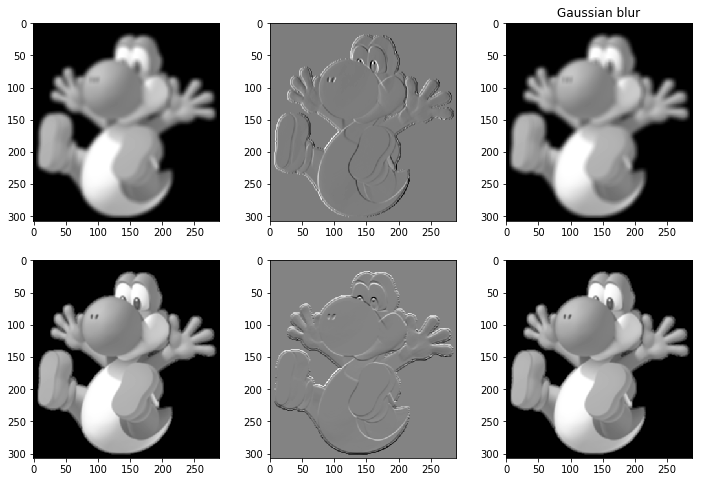

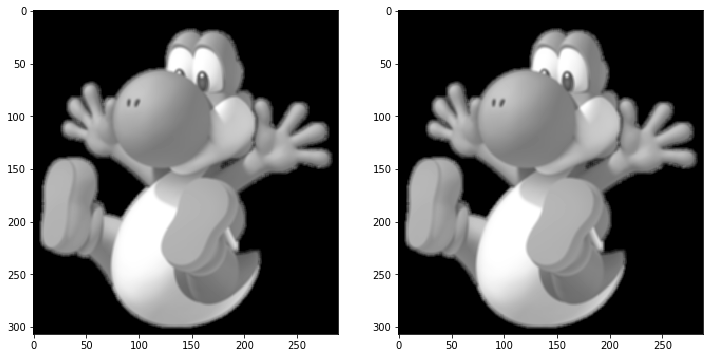

In [6]:
img_color = plt.imread('small_yoshi.png')
I_gray = img_color.mean(axis=2)

h9 = np.ones((9, 9))
h9 /= h9.sum()
h5 = np.ones((3, 3))
h5 /= h5.sum()
sobel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
gauss1 = gaussian(9, 5)
gauss2 = gaussian(3, 25)
g1 = convolve(I_gray, gauss1)
g2 = convolve(I_gray, gauss2)
sobel_u = convolve(I_gray, sobel)
sobel_v = convolve(I_gray, sobel.T)
avg1 = convolve(I_gray, h9)
avg2 = convolve(I_gray, h5)
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))
plt.gray()
ax[0, 0].imshow(g1)
ax[1, 0].imshow(g2)
ax[1, 1].imshow(sobel_v)
ax[0, 1].imshow(sobel_u)
ax[0, 2].imshow(avg1)
ax[0, 2].set_title("Gaussian blur")
ax[1, 2].imshow(avg2)
plt.show()
fig, ax = plt.subplots(ncols = 2, figsize=(12, 8))
ax[0].imshow(g2)
ax[1].imshow(avg2)
plt.show()

A gaussian kernel definitely preserves the resolution of the input image better than a box kernel of the same size. 

One issue that we have not discussed is what to do at boundaries.  This primarily becomes an issue when we want the output of our filter to be of the *same size as the input*.  As it is now, most of your code will produce a result that has width $n-(\mathrm{width}(h)-1)$ and height $m-(\mathrm{height}(h)-1)$.  How should we produce a filtered image that is $n \times m$?  A few methods are typical.  One choice is to change the kernel when we get to the edge.  This is particularly popular when computing derivatives, but necessitates that for every kernel we actually specify a hierarchy of kernels.  A popular option is to *wrap* the computation around to the other side of the image.  For example, when convolving a 3x3 kernel on the left boundary, the left three pixels are multiplied with the pixels from the same row on the right edge of the image.  This method makes sense for *periodic* signals, but most natural images are not like that (except for 360 degree panoramas!).  A more general (but perhaps less defensible) solution is to perform one of the following three operations: reflect, fill, and nearest neighbors.  Reflect does what the name sounds like: add fictitious columns (or rows) to the edge of the image, which have their values assigned by reflection.  Thus $g(j=u,k=-1) = g(j=u,k=1)$, $g(j=u,k=-2)=g(j=u,k=2)$, and so on.  Fill assigns the unknown values outside the image boundary to a particular constant.  Nearest neighbors assigns the unknown value to the value of the nearest point inside the image boundary.  **Implement a few of these last three boundary operations, such that your convolve function has the option to output an image of the same size as its input**.

In [7]:
def convolve_preserve(g, h, method='fill', value=0):
    ofs = h.shape[0] // 2
    tmp = np.ones((g.shape[0]+2*ofs, g.shape[1]+2*ofs))
    if method == 'fill':
        tmp *= value
        tmp[ofs:-ofs, ofs:-ofs] = g
        out = convolve(tmp, h)
        return out[ofs:-ofs, ofs:-ofs]
    elif method == 'mirror':
        tmp[ofs:-ofs, ofs:-ofs] = g
        tmp[:, 0:ofs] = tmp[:, ofs:2*ofs] # left
        tmp[:, -ofs:] = tmp[:, -2*ofs:-ofs] # right
        tmp[0:ofs:, ] = tmp[ofs:2*ofs:, ] # top
        tmp[-ofs:, ] = tmp[-2*ofs:-ofs, ] # bottom
        out = convolve(tmp, h)
        return out[ofs:-ofs, ofs:-ofs]
    else:
        # Nearest Neighbours
        tmp[:, 0:ofs] = array([tmp[:,ofs],]*ofs).transpose() # left
        tmp[:, -ofs:] = array([tmp[:,-ofs],]*ofs).transpose()  # right
        tmp[0:ofs:, ] = array([tmp[ofs,:],]*ofs) # top
        tmp[-ofs:, ] = array([tmp[-ofs,:],]*ofs) # bottom
        
        tmp[0,0] = tmp[ofs, ofs]
        tmp[0,-1] = tmp[ofs,-ofs]
        tmp[-1, 0] = tmp[-ofs, ofs]
        tmp[-1, -1] = tmp[-ofs, -ofs]
        
        out = convolve(tmp, h)
        return out[ofs:-ofs, ofs:-ofs]

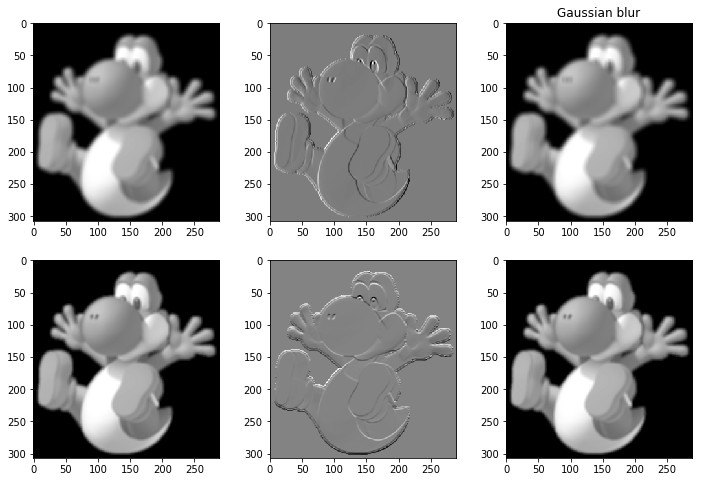

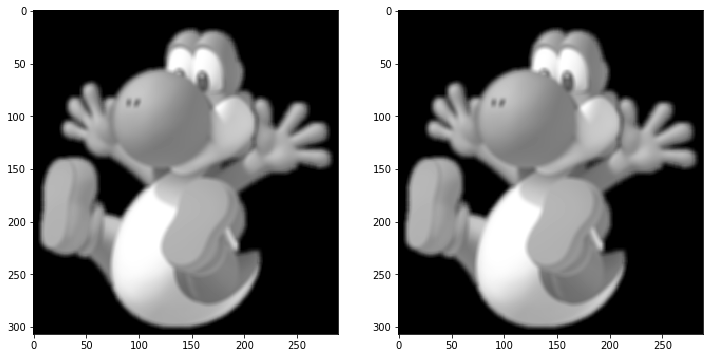

In [8]:
h9 = np.ones((9,9))
h9 /= h9.sum()
h5 = np.ones((5, 5))
h5 /= h5.sum()
sobel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
gauss1 = gaussian(9, 5)
gauss2 = gaussian(5, 25)
g1 = convolve_preserve(I_gray, gauss1)
g2 = convolve_preserve(I_gray, gauss2)
sobel_u = convolve_preserve(I_gray, sobel)
sobel_v = convolve_preserve(I_gray, sobel.T)
avg1 = convolve_preserve(I_gray, h9)
avg2 = convolve_preserve(I_gray, h5)
assert avg1.shape == I_gray.shape
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))
plt.gray()
ax[0, 0].imshow(g1)
ax[1, 0].imshow(g2)
ax[1, 1].imshow(sobel_v)
ax[0, 1].imshow(sobel_u)
ax[0, 2].imshow(avg1)
ax[0, 2].set_title("Gaussian blur")
ax[1, 2].imshow(avg2)
plt.show()
fig, ax = plt.subplots(ncols = 2, figsize=(12, 8))
ax[0].imshow(g2)
ax[1].imshow(avg2)
plt.show()